In [3]:
# 00_data_cleaning.ipynb
# Libraries and loading cleaned dataset / Librerías y carga del conjunto limpio
import pandas as pd
import numpy as np
import sys; from pathlib import Path 
sys.path.insert(0, str(Path.cwd().parent / "src"))
import runpy, os, warnings
from contextlib import redirect_stdout, redirect_stderr
warnings.filterwarnings("ignore")
with open(os.devnull, "w") as devnull, redirect_stdout(devnull), redirect_stderr(devnull):
    runpy.run_path(str(Path.cwd().parent / "src" / "load_data.py"), run_name="__main__")

In [5]:
# 1.) Load and inspect Greenhouse Gas Emissions Inventory ∣ Cargar e inspeccionar Inventario Gases de Efecto invernadero (GEI)
# https://datos.comunidad.madrid/dataset/atm_inventario_gei (Provides sectoral emissions data across the region since 1990.)
# → Use to identify high-emission zones and quantify heating-related emissions for Pareto.

from load_data import load_gei; df_gei = load_gei()
print(f"- shape: {df_gei.shape}\n- dtypes:\n{df_gei.dtypes}\n- head(1):\n{df_gei.head(1)}")

- shape: (5885, 6)
- dtypes:
inventario_gei_año               int64
inventario_gei_sector_crf       object
inventario_gei_categoria_crf    object
inventario_gei_actividad_crf    object
inventario_gei_contaminante     object
inventario_gei_gg_co2_eq        object
dtype: object
- head(1):
   inventario_gei_año inventario_gei_sector_crf  \
0                1990             CRF 1 Energía   

     inventario_gei_categoria_crf  \
0  1.A. Actividades de combustión   

                        inventario_gei_actividad_crf  \
0  1A1a Producción de energía y calor en plantas ...   

  inventario_gei_contaminante inventario_gei_gg_co2_eq  
0                         N2O              0,015104735  


### GEI Dataset Overview / Resumen del Inventario GEI

- **Shape / Dimensiones**: `(5885, 6)`  
- **Dtypes / Tipos de datos**:

| Column name                     | Type    | Meaning (EN)                                      | Significado (ES)                                      |
|--------------------------------|---------|--------------------------------------------------|--------------------------------------------------------|
| `inventario_gei_año`           | int     | Reference Year                                  | Año de Referencia                              |
| `inventario_gei_sector_crf`    | object  | CRF sector                                       | Sector CRF desde el que se emite el contaminante      |
| `inventario_gei_categoria_crf` | object  | CRF category                                     | Categoría CRF desde la que se emite el contaminante   |
| `inventario_gei_actividad_crf` | object  | CRF activity                                     | Actividad CRF desde la que se emite el contaminante   |
| `inventario_gei_contaminante`  | object  | Greenhouse gas type                              | Tipo de gas de efecto invernadero                     |
| `inventario_gei_gg_co2_eq`     | object  | Emissions in CO₂ equivalent (Gigagrams CO₂-eq)          | Emisiones en Gg equivalentes de CO₂                   |

> **Note / Nota**:  
> CRF (Common Reporting Format) is a standardized classification system defined by the UNFCCC  
> to report greenhouse gas emissions consistently by sector, category, and activity.  
> CRF (Formato Común de Reporte) es un sistema estandarizado definido por la CMNUCC  
> para reportar emisiones de gases de efecto invernadero de forma coherente por sector, categoría y actividad.

- **Head(1) / Primer registro**:

| Año  | Sector CRF     | Categoría CRF                  | Actividad CRF                                               | Contaminante | GEI CO₂ eq   |
|------|----------------|--------------------------------|--------------------------------------------------------------|--------------|--------------|
| 1990 | CRF 1 Energía  | 1.A. Actividades de combustión | 1A1a Producción de energía y calor en plantas públicas       | N₂O          | 0.015104735  |

In [ ]:
# 1.1) columns renaming / renombrado de columnas 
df_gei.rename(columns={
    "inventario_gei_año": "year",                      # Año
    "inventario_gei_sector_crf": "sector_crf",         # Sector CRF
    "inventario_gei_categoria_crf": "category_crf",    # Categoría CRF
    "inventario_gei_actividad_crf": "activity_crf",    # Actividad CRF
    "inventario_gei_contaminante": "pollutant",        # Contaminante
    "inventario_gei_gg_co2_eq": "co2_eq"               # GEI CO₂ equivalente
}, inplace=True)

In [7]:
# 1.2) change dtypes / cambio tipo de datos

# Co2 numeric / numerico
df_gei["co2_eq"] = df_gei["co2_eq"].str.replace(",", ".", regex=False).astype(float)

In [8]:
# 1.3) Check for Nulls, Uniques and Duplicates in numerical and categorical columns / Revisar nulos, únicos y duplicados en columnas
print(f"\n∑ Num cols: {df_gei.select_dtypes('number').columns.tolist()} | Nulls: {df_gei.select_dtypes('number').isnull().sum().to_dict()} | Dups: {df_gei.select_dtypes('number').duplicated().sum()} | Uniques: {df_gei.select_dtypes('number').nunique().to_dict()}\nⅭ Cat cols: {df_gei.select_dtypes('object').columns.tolist()} | Nulls: {df_gei.select_dtypes('object').isnull().sum().to_dict()} | Dups: {df_gei.select_dtypes('object').duplicated().sum()} | Uniques: {df_gei.select_dtypes('object').nunique().to_dict()}")


∑ Num cols: ['year', 'co2_eq'] | Nulls: {'year': 0, 'co2_eq': 0} | Dups: 276 | Uniques: {'year': 33, 'co2_eq': 5500}
Ⅽ Cat cols: ['sector_crf', 'category_crf', 'activity_crf', 'pollutant'] | Nulls: {'sector_crf': 0, 'category_crf': 0, 'activity_crf': 0, 'pollutant': 0} | Dups: 5692 | Uniques: {'sector_crf': 5, 'category_crf': 27, 'activity_crf': 129, 'pollutant': 6}


### GEI Dataset Diagnostics / Diagnóstico Data del Inventario GEI

#### ∑ Numeric Columns / Columnas Numéricas
- `year`: 33 unique years, no nulls → covers 1990–2022  
- `co2_eq`: 5500 unique values, no nulls → high granularity in emissions  
- Duplicates: 276 rows share identical year + co2_eq → likely same emissions across different CRF categories

#### Ⅽ Categorical Columns / Columnas Categóricas
- `sector_crf`: 5 unique sectors → compact CRF sector coverage  
- `category_crf`: 27 unique categories → moderate granularity  
- `activity_crf`: 129 unique activities → detailed CRF breakdown  
- `pollutant`: 6 unique gases → CH₄, CO₂, N₂O, SF₆, HFC, PFC  
- Duplicates: 5692 rows share identical categorical combinations → expected due to repeated structure across years

#### Interpretation / Interpretación
- No missing values → dataset is structurally complete  
- High uniqueness in `co2_eq` → emissions vary significantly by activity  
- CRF structure is dense → ideal for Pareto analysis and sectoral targeting  
- Duplicate rows are not errors — they reflect repeated CRF structure across years and pollutants

> CRF (Common Reporting Format) is a UNFCCC standard for reporting emissions by sector, category, and activity.  
> CRF (Formato Común de Reporte) es un estándar de la CMNUCC para reportar emisiones por sector, categoría y actividad.

In [9]:
# 1.4) No more cleaning, EDA ready / No hay necesidad de mas limpieza, lista para AED
# save / guardar
from load_data import save_clean
save_clean(df_gei, "gei.csv")

WindowsPath('C:/_Workspace/2_Work/1_Projects_Active/Low-Carbon-Heating-Roadmap-for-Madrid/data/clean/gei.csv')

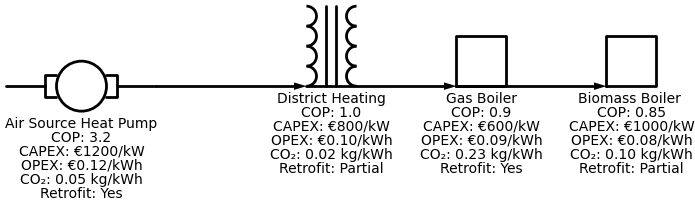

In [8]:
# 10.) tech specs for equipments / especificaciones para equipos.
import schemdraw
import schemdraw.elements as elm

with schemdraw.Drawing() as d:
    d.config(fontsize=10)

    # Air Source Heat Pump / Bomba de calor 
    d += elm.Motor().label('Air Source Heat Pump\nCOP: 3.2\nCAPEX: €1200/kW\nOPEX: €0.12/kWh\nCO₂: 0.05 kg/kWh\nRetrofit: Yes', loc='bottom')
    d += elm.Arrow().right()

    # District Heating / 
    d += elm.Transformer().label('District Heating\nCOP: 1.0\nCAPEX: €800/kW\nOPEX: €0.10/kWh\nCO₂: 0.02 kg/kWh\nRetrofit: Partial', loc='bottom')
    d += elm.Arrow().right()

    # Gas Boiler /
    d += elm.Rect().label('Gas Boiler\nCOP: 0.9\nCAPEX: €600/kW\nOPEX: €0.09/kWh\nCO₂: 0.23 kg/kWh\nRetrofit: Yes', loc='bottom')
    d += elm.Arrow().right()

    # Biomass Boiler /
    d += elm.Rect().label('Biomass Boiler \nCOP: 0.85\nCAPEX: €1000/kW\nOPEX: €0.08/kWh\nCO₂: 0.10 kg/kWh\nRetrofit: Partial', loc='bottom')

    d.save('heating_technologies_diagram.png')  # or .svg